__IMPORTING THE LIBRARIES USED__

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import ppscore as pps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_curve,auc
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import mutual_info_classif
import shap
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.stats import zscore
import math
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import VotingClassifier, StackingClassifier


__ALL FUNCTION USED__

In [2]:
def labelencoder_function(df):
    encoders = {}
    col = df.select_dtypes(include='object').columns
    for i in col:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
        encoders[i] = le  # Save encoder for that column
    return df, encoders

In [3]:
def correlation_table_display(df, feature_list, target_variable, df_name='Dataset'):
    print(f"{df_name} - Feature List and Target")
    print(feature_list, target_variable, sep='\n\n')

    cor = df.corr()
    cor_table = cor[target_variable].sort_values(ascending=False)

    print(f"\n{df_name} - Correlation Table:")
    print(cor_table)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cor_table.index, y=cor_table.values, hue=cor_table.index, palette="coolwarm", legend=False)
    plt.xticks(rotation=90)
    plt.ylabel("Correlation Coefficient")
    plt.title(f"Correlation with Target - {df_name}")
    plt.tight_layout()
    plt.show()
    print("-----------***--------------***-------------***")


In [4]:
def print_pps_score(df, feature_list, target_variable, df_name='Dataset'):
    print(f"{df_name} - Feature List and Target")
    print(feature_list, target_variable, sep='\n\n')

    pps_scores = {col: pps.score(df, col, target_variable)["ppscore"] for col in feature_list}
    pps_df = pd.DataFrame(pps_scores.items(), columns=['Feature', 'PPS'])

    pps_df = pps_df.sort_values(by="PPS", ascending=False)
    print(f"\n{df_name} - PPS Table:")
    print(pps_df)
    print("-----------***--------------***-------------***")


In [5]:
def vif_display(df, feature_list, target_variable, df_name="DataFrame"):
    print(f"{df_name} - Feature List and Target")
    print(feature_list, target_variable, sep='\n')
    print('\n')

    dfx = df[feature_list]
    x_const = add_constant(dfx)

    vif_data = pd.DataFrame()
    vif_data["Feature"] = dfx.columns
    vif_data["VIF"] = [variance_inflation_factor(x_const.values, i + 1) for i in range(len(dfx.columns))]
    vif_data = vif_data.sort_values(by="VIF", ascending=False)

    def color_map(vif):
        if vif <= 10:
            return 'green'
        elif vif <= 100:
            return 'orange'
        else:
            return 'red'

    colors = vif_data["VIF"].apply(color_map)

    print(vif_data)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=vif_data, x='Feature', y='VIF', color='lightblue')  # base color

    for bar, color in zip(ax.patches, colors):
        bar.set_color(color)

    plt.xticks(rotation=90)
    plt.ylabel("VIF Value")
    plt.title(f"Variance Inflation Factor (VIF) - {df_name}")
    plt.tight_layout()
    plt.show()
    print("-----------***--------------***-------------***")

In [6]:
def mi_score_display(df, feature_list, target_variable, df_name="DataFrame"):
    print(f"{df_name} - Feature List and Target")
    print(feature_list, target_variable, sep='\n')
    print('\n')

    mi_x = df[feature_list]
    mi_y = df[target_variable]

    # Calculate Mutual Information Scores
    mi_scores = mutual_info_classif(mi_x, mi_y, discrete_features='auto', random_state=0)
    mi_df = pd.DataFrame({'Feature': mi_x.columns, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by='MI Score', ascending=False)

    # Define color threshold
    def color_map(score):
        if score > 0.2:
            return 'purple'
        elif score > 0.1:
            return 'orange'
        else:
            return 'gray'

    colors = mi_df['MI Score'].apply(color_map)

    # Print the table
    print(mi_df)

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=mi_df, x='Feature', y='MI Score', color='skyblue')  # base color

    for bar, color in zip(ax.patches, colors):
        bar.set_color(color)

    plt.xticks(rotation=90)
    plt.title(f"Mutual Information Scores - {df_name}")
    plt.tight_layout()
    plt.show()
    print("-----------***--------------***-------------***")

In [7]:
def outlier_removal(df, target='isFraud'):
    dfnew = df.copy()
    original_rows = len(df)

    for col in df.select_dtypes(include='number').columns:
        if col == target:
            continue

        Q1 = dfnew[col].quantile(0.25)
        Q3 = dfnew[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = ~((dfnew[target] == 0) & ((dfnew[col] < lower) | (dfnew[col] > upper)))
        dfnew = dfnew[mask]

    new_rows = len(dfnew)
    removed_rows = original_rows - new_rows

    print(f"Original rows: {original_rows}")
    print(f"Rows after outlier removal: {new_rows}")
    print(f"Rows removed: {removed_rows} ({removed_rows / original_rows:.2%} of the data)")

    return dfnew


In [8]:
def plot_normal_distribution_curves(df, feature_list):
    num_features = len(feature_list)
    ncols = 3  # Number of plots per row
    nrows = (num_features + ncols - 1) // ncols

    plt.figure(figsize=(5 * ncols, 4 * nrows))

    for idx, col in enumerate(feature_list):
        plt.subplot(nrows, ncols, idx + 1)
        
        # Drop NaNs if any
        data = df[col].dropna()
        
        # Plot histogram
        sns.histplot(data, bins=30, kde=False, stat="density", color="skyblue", edgecolor='black')
        
        # Fit a normal distribution
        mu, std = norm.fit(data)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        
        # Plot the normal curve
        plt.plot(x, p, 'r', linewidth=2)
        
        plt.title(f"{col}\nMean={mu:.2f}, Std={std:.2f}")
        plt.xlabel(col)
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

In [9]:
def standard_scaler(df, feature_list):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[feature_list])
    scaled_df = pd.DataFrame(scaled_data, columns=feature_list)
    df[feature_list] = scaled_df

    return df

In [ ]:
def evaluate_model(name, model, x_test, y_test, thresholds=[0.45, 0.40, 0.35, 0.30]):
    print(f"\n📊 Results for: {name}")
    
    try:
        probs = model.predict_proba(x_test)[:, 1]
    except AttributeError:
        print("⚠️ This model does not support predict_proba.")
        return

    for thresh in thresholds:
        print(f"\n🔍 Threshold: {thresh}")
        y_pred = (probs >= thresh).astype(int)

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"{name} - Threshold: {thresh}")
        plt.show()

        print(classification_report(y_test, y_pred))


__IMPORTING THE CSV FILE__

In [11]:
df = pd.read_csv("Fraud.csv")

__BASIC EDA__

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [13]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [14]:
df.shape

(6362620, 11)

***LABEL ENCODING***

In [15]:
df, encoders = labelencoder_function(df)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [16]:
feature = [i for i in df.columns if i != 'isFraud']
print(feature)
target = 'isFraud'

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


***Scaling The Features***

In [17]:
df_scaled = standard_scaler(df, feature)

***Outlier Removal***

In [18]:
df_outlier_removed = outlier_removal(df)

Original rows: 6362620
Rows after outlier removal: 3206289
Rows removed: 3156331 (49.61% of the data)


In [19]:
df_scaled_outlier_removed = outlier_removal(df_scaled)

Original rows: 6362620
Rows after outlier removal: 3206289
Rows removed: 3156331 (49.61% of the data)


***Dictionary of all DataFrames***

In [20]:
dataframe_dict = {
    'Normal df' : df,
    'Scaled df' : df_scaled,
    'Outlier_removed_Normal_df' : df_outlier_removed,
    'Outlier_removed_Scaled_df' : df_scaled_outlier_removed
}

__ADVANCE EDA__

***output in the text files***

In [ ]:
for name, df_type in dataframe_dict.items():
     correlation_table_display(df_type, feature, target, df_name= name)
     print_pps_score(df_type, feature, target, df_name= name)
     vif_display(df_type, feature, target, df_name= name)
     mi_score_display(df_type, feature, target, df_name= name)

***Dataframes Without Outlier had much better characteristics with respect to Target***

In [22]:
dataframe_to_be_used = {
    'Outlier_removed_Normal_df' : df_outlier_removed,
    'Outlier_removed_Scaled_df' : df_scaled_outlier_removed
}

__GROUP BASED ANALYSIS__

***COLUMN = TYPE***

       type  isFraud
0 -0.528954     4116
1  1.693076     4097


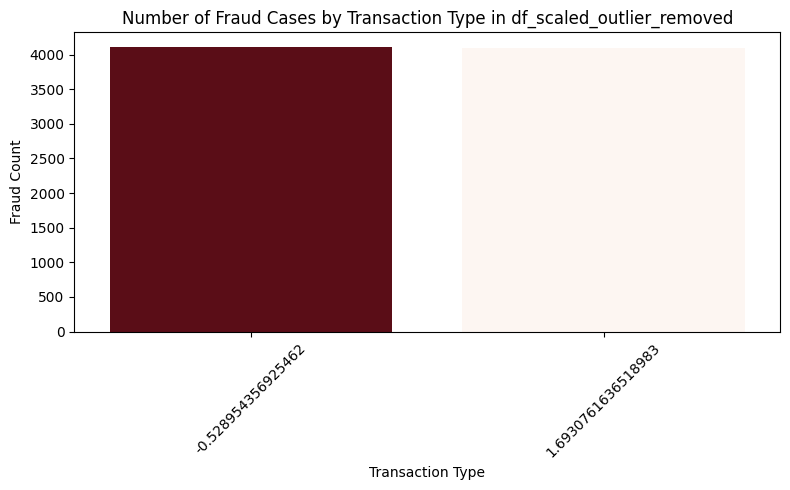

In [23]:
fraud_count_by_type = df_scaled_outlier_removed[df_scaled_outlier_removed['isFraud'] == 1].groupby('type')['isFraud'].count().reset_index()
fraud_count_by_type = fraud_count_by_type.sort_values(by='isFraud', ascending=False)

print(fraud_count_by_type)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=fraud_count_by_type, x='type', y='isFraud', hue='type', palette='Reds_r', legend=False)
plt.title(f"Number of Fraud Cases by Transaction Type in df_scaled_outlier_removed")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***COLUMN = STEP***

In [24]:
totalsteps = len(df_scaled_outlier_removed['step'].value_counts())
total1 = len(df_scaled_outlier_removed[df_scaled_outlier_removed['isFraud'] == 1])

fraud_count_by_step = df_scaled_outlier_removed[df_scaled_outlier_removed['isFraud'] == 1].groupby('step').size().reset_index(name='count')
average_fraud_count = fraud_count_by_step['count'].mean()
above_avg_fraud = fraud_count_by_step[fraud_count_by_step['count'] > average_fraud_count]
above_avg_fraud = above_avg_fraud.sort_values(by='count', ascending=False).reset_index(drop=True)
above_avg_fraud.head(326)

,step,count
0,-0.220592,40
1,1.964441,30
2,1.809873,28
3,1.008928,28
4,1.275910,28
...,...,...
321,2.357888,12
322,-0.262747,12
323,2.343836,12
324,-0.206540,12


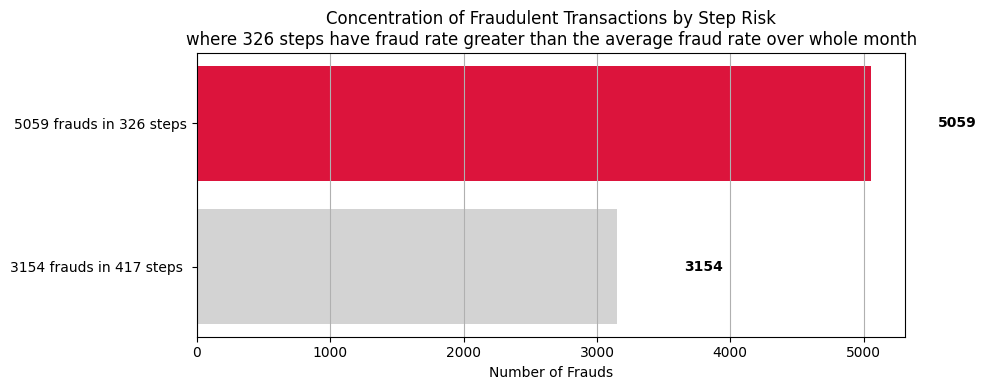

In [25]:
total_count = above_avg_fraud['count'].sum()
fraud_counts = [total1 - total_count, total_count]
step_counts = [totalsteps - 326, 326]
labels = [
    f"{total1 - total_count} frauds in {totalsteps - 326} steps ",
    f"{total_count} frauds in 326 steps"
]
colors = ['lightgray', 'crimson']

# Plot
plt.figure(figsize=(10, 4))
bars = plt.barh(labels, fraud_counts, color=colors)

# Annotate
for bar in bars:
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2,
            f"{width}", va='center', fontweight='bold')

plt.title("Concentration of Fraudulent Transactions by Step Risk\nwhere 326 steps have fraud rate greater than the average fraud rate over whole month")
plt.xlabel("Number of Frauds")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

***COLUMN = AMOUNT***

In [26]:
max_val = df_scaled_outlier_removed['amount'].max()
min_val = df_scaled_outlier_removed['amount'].min()
print(max_val, min_val, sep=" ")
diff = max_val - min_val
print(diff)
num_bins = 1000
print(diff/num_bins)

bin_width = diff/num_bins
bin_edges = np.arange(min_val, max_val + bin_width, bin_width)
labels = [f"{round(start, 2)}–{round(end, 2)}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]


fraud_df_by_amount = df_scaled_outlier_removed[df_scaled_outlier_removed['isFraud'] == 1].copy()
fraud_df_by_amount['amount_range'] = pd.cut(fraud_df_by_amount['amount'], bins=bin_edges, labels=labels, right=False)
range_counts = fraud_df_by_amount['amount_range'].value_counts().sort_index().reset_index()
range_counts.columns = ['Amount Range', 'Fraud_Count']
sorted_range_counts = range_counts.sort_values(by='Fraud_Count', ascending=False).reset_index(drop=True)
sorted_range_counts


16.262325089724712 -0.29785454318914306
16.560179632913854
0.016560179632913855


,Amount Range,Fraud_Count
0,-0.3–-0.28,278
1,-0.26–-0.25,211
2,-0.28–-0.26,188
3,-0.25–-0.23,181
4,-0.23–-0.22,180
...,...,...
995,10.98–11.0,0
996,10.96–10.98,0
997,10.95–10.96,0
998,10.93–10.95,0


In [27]:
print(sorted_range_counts['Fraud_Count'].sum())
sum = 0
for i in range(100):
    sum += sorted_range_counts['Fraud_Count'][i]

print(sum)
top_100_ranges = range_counts.head(100).sort_values(by='Fraud_Count', ascending=False)

7926
5577


__FEATURE ENGINEERING__

In [28]:
df_scaled_outlier_removed.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

***Columns Removed Due to high Multicollinearty***

In [29]:
df_scaled_outlier_removed["old_balance_change"] = df_scaled_outlier_removed['oldbalanceOrg'] - df_scaled_outlier_removed['oldbalanceDest']
df_scaled_outlier_removed["old_balance_change%"] = ((df_scaled_outlier_removed['oldbalanceOrg'] - df_scaled_outlier_removed['oldbalanceDest'])/df_scaled_outlier_removed['oldbalanceOrg'])*100

df_scaled_outlier_removed['new_balance_change'] = df_scaled_outlier_removed['newbalanceOrig'] - df_scaled_outlier_removed['newbalanceDest']
df_scaled_outlier_removed["new_balance_change%"] = ((df_scaled_outlier_removed['newbalanceOrig'] - df_scaled_outlier_removed['newbalanceDest'])/df_scaled_outlier_removed['oldbalanceOrg'])*100

df_scaled_outlier_removed.drop(columns=['oldbalanceOrg', 'oldbalanceDest', 'newbalanceOrig', 'newbalanceDest', 'nameOrig', 'nameDest'], inplace=True)

df_scaled_outlier_removed.columns

Index(['step', 'type', 'amount', 'isFraud', 'isFlaggedFraud',
       'old_balance_change', 'old_balance_change%', 'new_balance_change',
       'new_balance_change%'],
      dtype='object')

__EDA FOR THE FINAL DATASET__

In [30]:
features = []
for i in df_scaled_outlier_removed.columns:
    if i != 'isFraud':
        features.append(i)

print(features)

target = 'isFraud'

['step', 'type', 'amount', 'isFlaggedFraud', 'old_balance_change', 'old_balance_change%', 'new_balance_change', 'new_balance_change%']


df_scaled_outlier_removed - Feature List and Target
['step', 'type', 'amount', 'isFlaggedFraud', 'old_balance_change', 'old_balance_change%', 'new_balance_change', 'new_balance_change%']

isFraud

df_scaled_outlier_removed - Correlation Table:
isFraud                1.000000
amount                 0.394537
old_balance_change     0.197355
step                   0.049818
isFlaggedFraud         0.044081
old_balance_change%    0.029552
type                   0.016146
new_balance_change%    0.008132
new_balance_change    -0.099030
Name: isFraud, dtype: float64


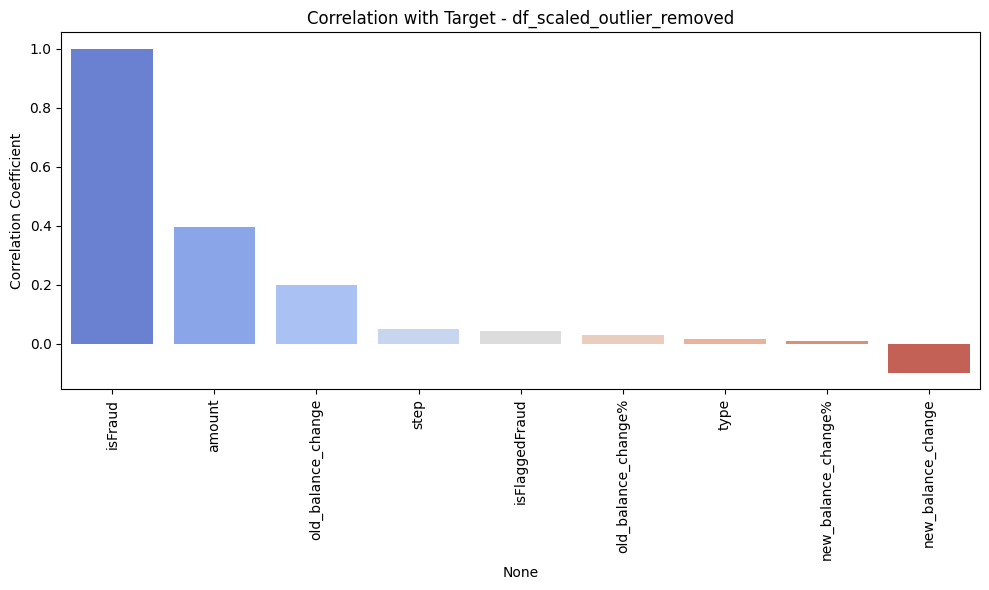

-----------***--------------***-------------***


In [31]:
correlation_table_display(df_scaled_outlier_removed, features, target, df_name='df_scaled_outlier_removed')

In [32]:
print_pps_score(df_scaled_outlier_removed, features, target, df_name='df_scaled_outlier_removed')

df_scaled_outlier_removed - Feature List and Target
['step', 'type', 'amount', 'isFlaggedFraud', 'old_balance_change', 'old_balance_change%', 'new_balance_change', 'new_balance_change%']

isFraud

df_scaled_outlier_removed - PPS Table:
               Feature       PPS
5  old_balance_change%  0.333333
4   old_balance_change  0.200000
0                 step  0.000000
1                 type  0.000000
2               amount  0.000000
3       isFlaggedFraud  0.000000
6   new_balance_change  0.000000
7  new_balance_change%  0.000000
-----------***--------------***-------------***


df_scaled_outlier_removed - Feature List and Target
['step', 'type', 'amount', 'isFlaggedFraud', 'old_balance_change', 'old_balance_change%', 'new_balance_change', 'new_balance_change%']
isFraud


               Feature        VIF
6   new_balance_change  15.341848
4   old_balance_change  14.065192
2               amount   7.206891
1                 type   1.287467
7  new_balance_change%   1.084964
5  old_balance_change%   1.068559
3       isFlaggedFraud   1.033998
0                 step   1.000532


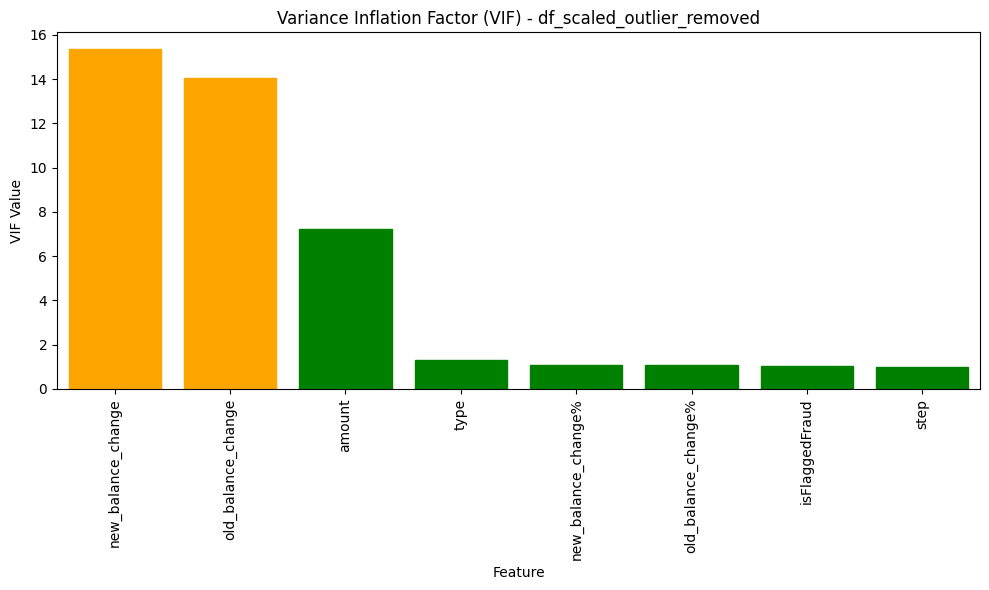

-----------***--------------***-------------***


In [33]:
vif_display(df_scaled_outlier_removed, features, target, df_name='df_scaled_outlier_removed')

df_scaled_outlier_removed - Feature List and Target
['step', 'type', 'amount', 'isFlaggedFraud', 'old_balance_change', 'old_balance_change%', 'new_balance_change', 'new_balance_change%']
isFraud


               Feature  MI Score
1                 type  0.241949
6   new_balance_change  0.035535
4   old_balance_change  0.026340
5  old_balance_change%  0.012042
0                 step  0.011770
2               amount  0.009273
7  new_balance_change%  0.008555
3       isFlaggedFraud  0.000990


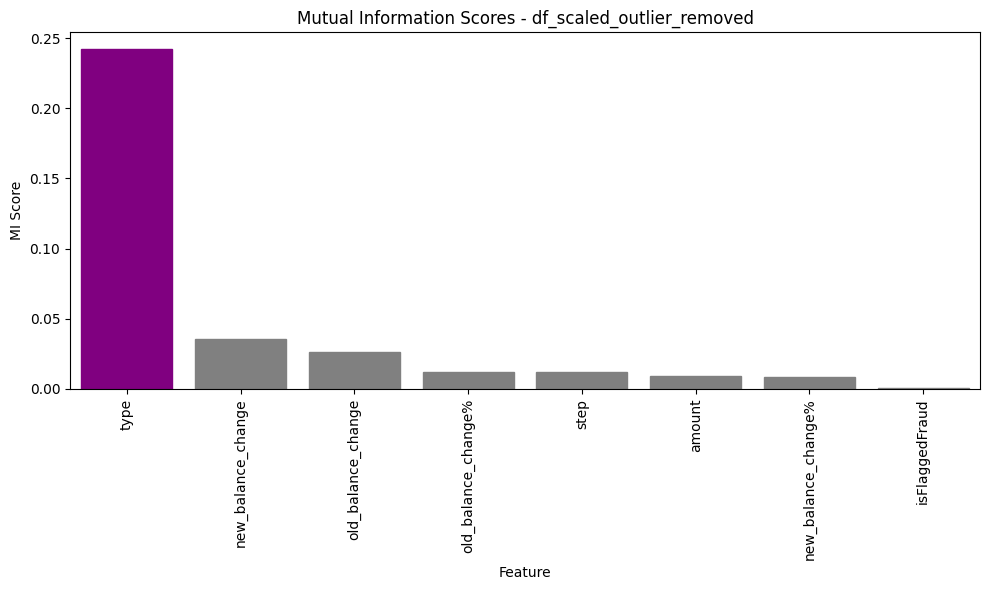

-----------***--------------***-------------***


In [36]:
mi_score_display(df_scaled_outlier_removed, features, target, df_name='df_scaled_outlier_removed')

__MODELLING__

In [37]:
training_feature = ['step', 'type', 'amount', 'old_balance_change', 'old_balance_change%', 'new_balance_change', 'new_balance_change%']
target = 'isFraud'

x = df_scaled_outlier_removed[training_feature]
y = df_scaled_outlier_removed[target]

In [38]:
x.shape, y.shape

((3206289, 7), (3206289,))

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2244402, 7), (961887, 7), (2244402,), (961887,))

***TREE MODELS ARE BEST FOR SUCH IMBALANCED DATASETS***

In [44]:
tree_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, criterion='gini'),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, verbose=0),
    "Extra Trees": ExtraTreesClassifier(n_estimators=50, random_state=42, verbose=0),
    "XGBoost": XGBClassifier(n_estimators=50, random_state=42, verbosity=0),
    "Histogram-based Gradient Boosting": HistGradientBoostingClassifier(
        l2_regularization=1.0,
        learning_rate=0.1,
        max_depth=10,
        max_iter=60,
        max_leaf_nodes=31,
        random_state=42
    )
}

***RESULTS***

Training Decision Tree

📊 Results for: Decision Tree

🔍 Threshold: 0.45


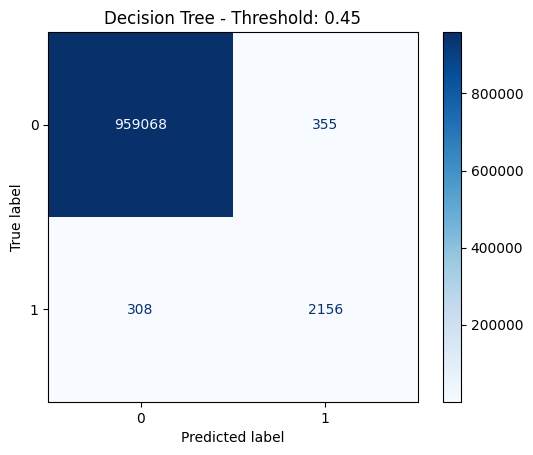

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.86      0.88      0.87      2464

    accuracy                           1.00    961887
   macro avg       0.93      0.94      0.93    961887
weighted avg       1.00      1.00      1.00    961887

Training Random Forest

📊 Results for: Random Forest

🔍 Threshold: 0.45


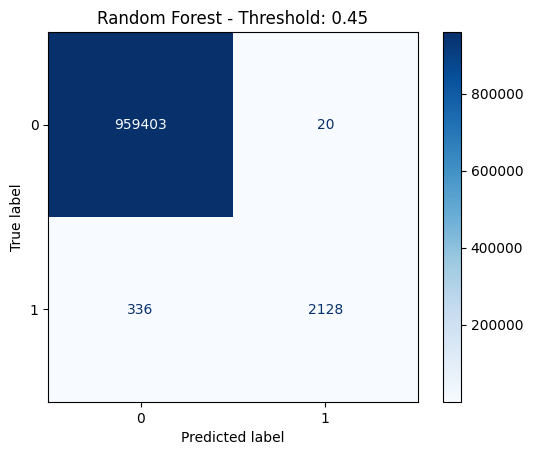

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.99      0.86      0.92      2464

    accuracy                           1.00    961887
   macro avg       1.00      0.93      0.96    961887
weighted avg       1.00      1.00      1.00    961887

Training Extra Trees

📊 Results for: Extra Trees

🔍 Threshold: 0.45


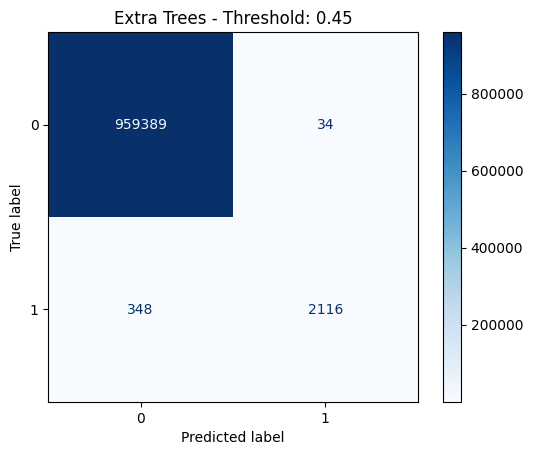

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.98      0.86      0.92      2464

    accuracy                           1.00    961887
   macro avg       0.99      0.93      0.96    961887
weighted avg       1.00      1.00      1.00    961887

Training XGBoost

📊 Results for: XGBoost

🔍 Threshold: 0.45


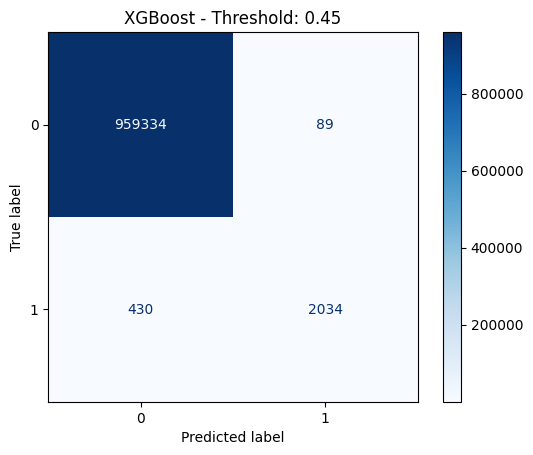

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.96      0.83      0.89      2464

    accuracy                           1.00    961887
   macro avg       0.98      0.91      0.94    961887
weighted avg       1.00      1.00      1.00    961887

Training Histogram-based Gradient Boosting

📊 Results for: Histogram-based Gradient Boosting

🔍 Threshold: 0.45


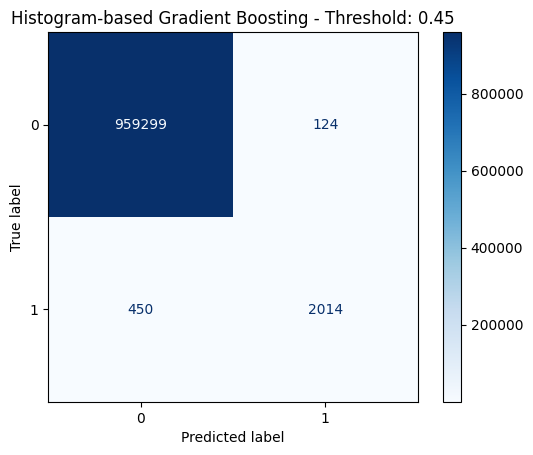

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.94      0.82      0.88      2464

    accuracy                           1.00    961887
   macro avg       0.97      0.91      0.94    961887
weighted avg       1.00      1.00      1.00    961887



In [49]:
for name, model in tree_models.items():
    print(f"Training {name}")
    model.fit(x_train,y_train)
    evaluate_model(name, model, x_test, y_test, thresholds=[0.45])

***Concept of Ensembling***


📊 Results for: Ensemble Voting

🔍 Threshold: 0.45


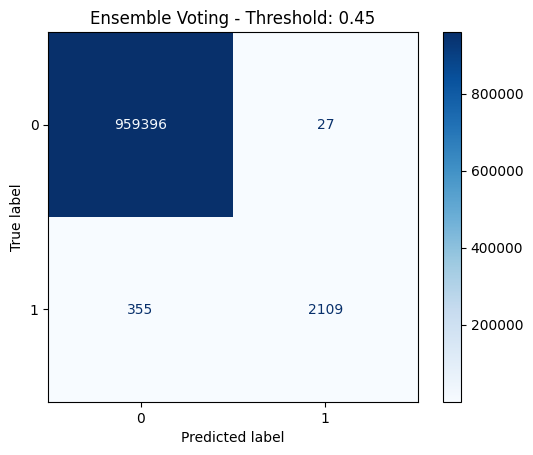

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.99      0.86      0.92      2464

    accuracy                           1.00    961887
   macro avg       0.99      0.93      0.96    961887
weighted avg       1.00      1.00      1.00    961887



In [53]:
ensemble = VotingClassifier(
    estimators=[
        ('rf', tree_models['Random Forest']),
        ('et', tree_models['Extra Trees']),
        ('xgb', tree_models['XGBoost']),
        ('hgb', tree_models['Histogram-based Gradient Boosting'])
    ],
    voting='soft'  # Use 'hard' if you want majority class votes
)

ensemble.fit(x_train, y_train)
evaluate_model("Ensemble Voting", ensemble, x_test, y_test, thresholds=[0.45])

In [57]:
f1_scores = {
    'Random Forest' : 0.92,
    'Extra Trees' : 0.92,
    'XGBoost' : 0.89,
    'Histogram-based Gradient Boosting' : 0.88
}
del sum

In [58]:
total = sum(f1_scores.values())
weights = {name: score / total for name, score in f1_scores.items()}

print("\n🔢 Normalized Weights (sum to 1):")
for name, weight in weights.items():
    print(f"{name}: {weight:.4f}")


🔢 Normalized Weights (sum to 1):
Random Forest: 0.2548
Extra Trees: 0.2548
XGBoost: 0.2465
Histogram-based Gradient Boosting: 0.2438


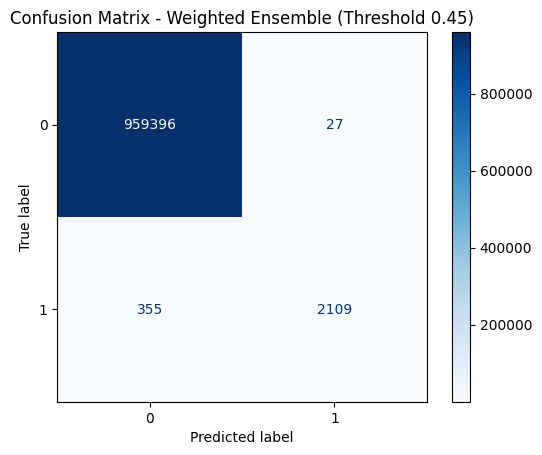


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.99      0.86      0.92      2464

    accuracy                           1.00    961887
   macro avg       0.99      0.93      0.96    961887
weighted avg       1.00      1.00      1.00    961887



In [60]:
weighted_probs = [
    model.predict_proba(x_test)[:, 1] * weights[name]
    for name, model in tree_models.items() if name != 'Decision Tree'
]

ensemble_probs = sum(weighted_probs)
y_pred_ensemble = (ensemble_probs >= 0.45).astype(int)

cm = confusion_matrix(y_test, y_pred_ensemble)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Weighted Ensemble (Threshold 0.45)")
plt.show()

# 📋 Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))


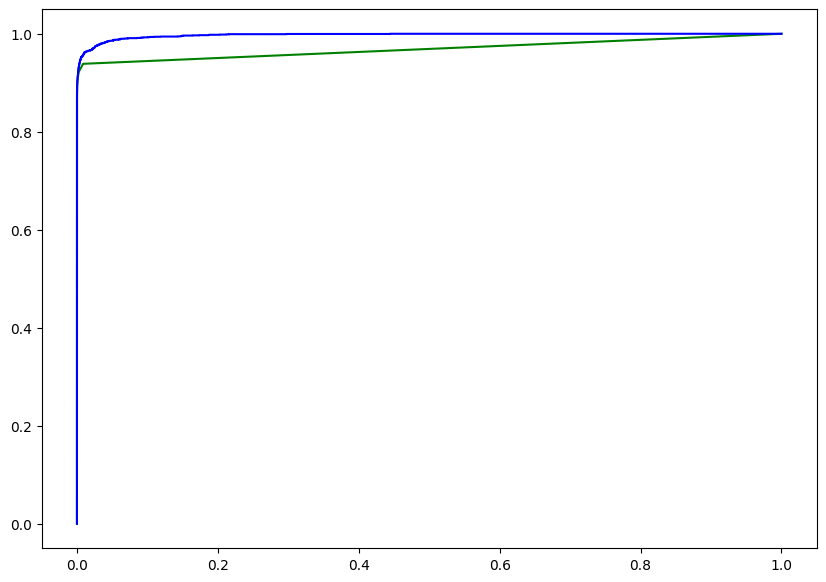

In [68]:
colors = {
    'Random Forest': 'green',
    'Voting': 'blue',
    'Weighted Voting': 'orange'
}

M1 = {
    'Random Forest': tree_models['Random Forest'],
    'Voting': ensemble
}

plt.figure(figsize=(10, 7))

for name, model in M1.items():
    y_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=colors[name])

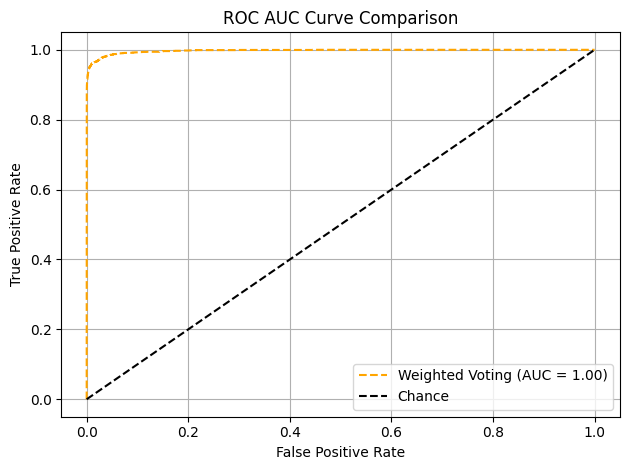

In [66]:
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Weighted Voting (AUC = {roc_auc:.2f})', linestyle='--', color=colors['Weighted Voting'])

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Plot styling
plt.title('ROC AUC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

__FINALLY__

we have, the following Models performing the best 

__RANDOM FOREST CLASSIFER__

__VOTING CLASSIFIER__

__WEIGHTAGE ENSEMBLING__


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959423
           1       0.99      0.86      0.92      2464
